# Проверка нормальности распределения логарифмированной дневной доходности (далее - ЛДД) фьючерса на индекс РТС.

## Описание:

Одним из допущений, содержащихся в формуле Блека - Шоулза является нормальность распределения ЛДД.

Вторым, столь же смелым допущением является константность дисперии доходностей.

Здесь проведем проверку ЛДД на соответствие нормальному распределению с применением теста Шапиро - Уилка на примере фьючерса на индекс РТС с экспирацией в сентябре 2022.

## Необходимые импорты:

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

## Пользовательские функции

#### Парсинг и предобработка файла с котировками

In [3]:
def parse_csv(parse_from_,
              sep_ = ',',
              enc_ = None,
              datetime_format_ = '%Y.%m.%d',
              columns_ = None,
              set_target_ = True):
    df = pd.read_csv(parse_from_, sep = sep_, encoding = enc_)
    if columns_:
        df.columns = columns_
    df['date'] = pd.to_datetime(df['date'], format = datetime_format_)
    df = df.sort_values(by = 'date')
    df.set_index('date', inplace = True)
    if set_target_:
        df = df[['adj_price']]
    return df

#### Проверка на нормальность распределения

In [4]:
def lognorm_tests(df):
    ln_r = pd.Series(df.ln_returns.dropna(), name = 'RTS ln(returns)')
    print('График дневных логарифмированных доходностей')
    ln_r.plot(figsize = (15, 9), legend = True)
    plt.show()
    m = ln_r.mean()
    std = ln_r.std()
    normalized = (ln_r - m) / std
    print('Гистограмма и QQ- plot ЛДД')
    f, ax = plt.subplots(2, figsize = (15, 15), sharex = True)
    normalized.hist(bins = 50, ax = ax[0])
    sm.qqplot(normalized, line ='45', ax = ax[1])
    plt.show()
    print('Тест Шапиро - Уилка')
    stat, p = shapiro(ln_r)
    print(f'stat={stat:.3f}, p={p:.3f}')
    if p > 0.05:
        print('H0: the sample has a Gaussian distribution. H0 can not be rejected.')
    else:
        print('H0: the sample has a Gaussian distribution. H0 is rejected.')

## Загрузка данных и обзор датафрейма

In [5]:
RTS = parse_csv('FUTURES/RTS/RTS-12.22.csv')

In [6]:
RTS

,adj_price
date,
2020-12-11,130870
2020-12-14,129990
2020-12-15,129010
2020-12-16,131010
2020-12-17,133050
...,...
2022-12-09,109890
2022-12-12,109130
2022-12-13,109050


In [7]:
RTS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 510 entries, 2020-12-11 to 2022-12-15
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   adj_price  510 non-null    int64
dtypes: int64(1)
memory usage: 8.0 KB


In [8]:
RTS.isna().sum()

adj_price    0
dtype: int64

In [9]:
RTS.index.is_monotonic

True

## Расчет ЛДД

In [10]:
RTS['ln_returns'] = np.log(RTS['adj_price'].pct_change() + 1)

## Тест

График дневных логарифмированных доходностей


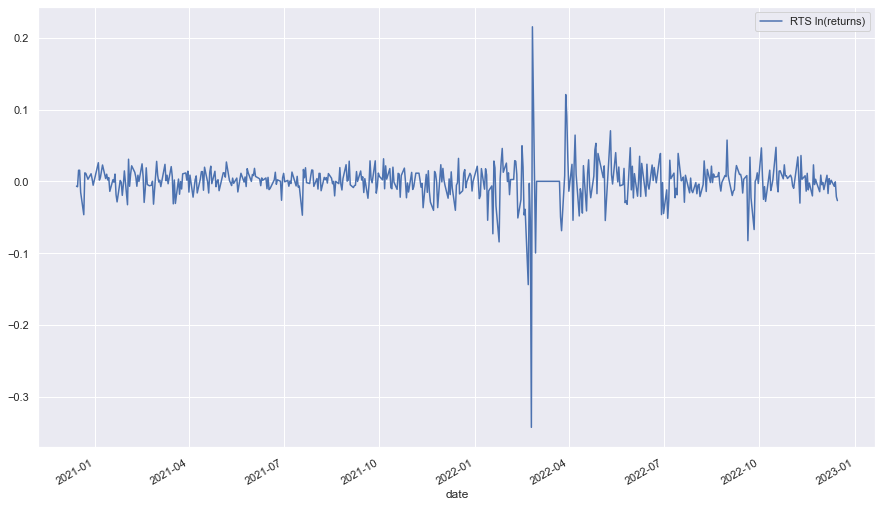

Гистограмма и QQ- plot ЛДД


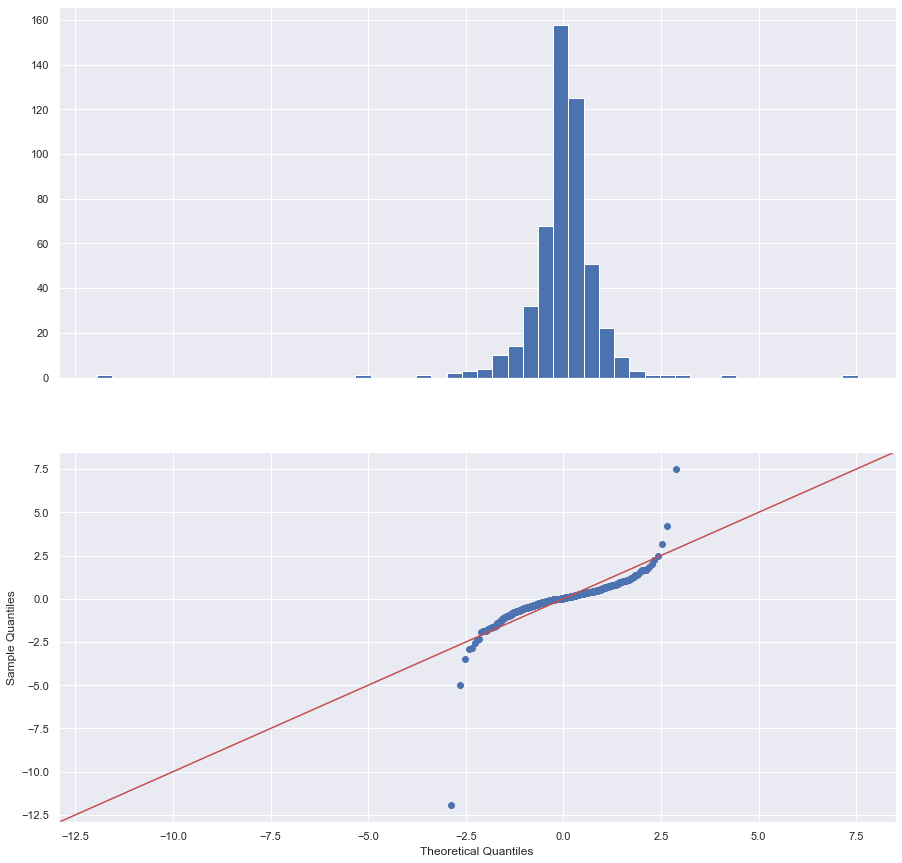

Тест Шапиро - Уилка
stat=0.716, p=0.000
H0: the sample has a Gaussian distribution. H0 is rejected.


In [11]:
lognorm_tests(RTS)

## Выводы:

На первом графике видим всплеск доходностей в феврале - марте 2022.

Гистограмма распределения доходностей визуально весьма близка нормальному распределению, однако, экстремальные значения лежат даже на взгляд существенно дальше трех сигм.

QQ - plot позволяет сравнить фактические данные распределения (синие точки) с некоторым эталонным нормальным распределением (красная линия). Мы можем наблюдать, что вблизи медианы распределение доходностей относительно близко нормальному, однако сильно отличается ближе к краям.

Тест Шапиро - Уилка подтверждает, что гипотеза о нормальности распределения (нулевая гипотеза в данном случае) статистически не может быть подтверждена.

Таким образом, следует констатировать, что модель Блека - Шоулза исходит из ложной предпосылки о нормальности распределения ЛДД и нуждается в корректировке.